# Homework 5: Confusion Matrix. ROC. AUC.

# Part 1
You will predict for an insuarance company how likely the person will be admitted to a hospital within the next year `DaysInHospital_Y2.csv`. The following data is provided: paitients' information `Members.csv` (age, sex) medical services provided in the previous year `Claims_Y1.csv` (provider, doctor, illness, days in hospital, etc. ).
Data source: https://www.kaggle.com/competitions/hhp/overview

You can dounload files directly from https://github.com/truongkhanhduy95/Heritage-Health-Prize/tree/master/data (click *Raw data* and copy the path). **If you use this repo, use 'Claims.csv' instead of 'Claims_Y1.csv'**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_4773/2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#1. (2pt) Read the data using parameter index_col = `MemberID`.

* table 'DaysInHospital_Y2.csv' into variable `days2`
* table 'Members.csv' into variable `m`
* table 'Claims_Y1.csv' into variable `claims`

In [2]:
path = 'https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/'

In [3]:
m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m.head()

,AgeAtFirstClaim,Sex
MemberID,,
14723353,70-79,M
75706636,70-79,M
17320609,70-79,M
69690888,40-49,M
33004608,0-9,M


In [4]:
claims=pd.read_csv(path+'Claims.csv',index_col='MemberID')
claims.head()

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [11]:
days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2.head()

,ClaimsTruncated,DaysInHospital
MemberID,,
24027423,0,0
98324177,0,0
33899367,1,1
5481382,0,1
69908334,0,0


To anonymize the data, the organizer provided approximate information about patients, for example, in the Age column, age groups are specified: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. We will convert string features into numerical ones and replace missing values.

In [7]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

/tmp/ipykernel_38962/3634060461.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)


Let's construct features based on the array of medical service cases:
* `f_Charlson` — the maximum Charlson comorbidity index among all cases for the patient (`CharlsonIndex` in the table `claims`)
* `f_LengthOfStay` —  the total number of hospitalization days in the past year  (`LengthOfStay` in the table `claims`)


In [8]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

We will create a feature matrix with the following columns: `f_Charlson`, `f_LengthOfStay`, `AgeAtFirstClaim`, `ClaimsTruncated` (whether there were too many medical service cases).

In [9]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,
24027423,0,3,0,30
98324177,0,0,0,30
33899367,1,0,0,80
5481382,0,0,1,20
69908334,0,1,0,60


## 2. (1pt) Add to the features columm `Sex`

In [12]:
X = X.join(m.Sex)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
24027423,0,3,0,30,M
98324177,0,0,0,30,M
33899367,1,0,0,80,F
5481382,0,0,1,20,F
69908334,0,1,0,60,F


## 3. (1pt) Split the date X and y into Train/Validation/Test sets in the following proportion: 50/25/25.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.5, random_state=42)

In [20]:
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.5, random_state=42)

In [15]:
X_train.shape

(38019, 5)

In [16]:
y_train.shape

(38019,)

In [17]:
X_validation.shape

(38019, 5)

In [18]:
y_validation.shape

(38019,)

In [21]:
X_test.shape

(19010, 5)

In [22]:
y_test.shape

(19010,)

In [23]:
X_train.Sex

MemberID
78411929      M
98508908      M
70301481    NaN
56730824      M
24399252    NaN
           ... 
98981446    NaN
23520654    NaN
69877219      F
42414011      F
44296471      F
Name: Sex, Length: 38019, dtype: object

## 4. (1pt) The column `Sex` contains missing values. Create the column transformer that will apply One-Hot-Encoder to this column with parameter `handle_unknown='infrequent_if_exist'`. It will create automatically `'OneHot__Sex_nan'` column afer fitting this transformer on the Train set. (Don't forget parameter `reminder`)

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [25]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ["Sex"])], remainder='passthrough')
transform.fit(X_train)
pd.DataFrame(transform.transform(X_train), columns=transform.get_feature_names_out()).head()

,OneHot__Sex_F,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,0.0,1.0,0.0,0.0,0.0,1.0,10.0
1,0.0,1.0,0.0,0.0,0.0,0.0,60.0
2,0.0,0.0,1.0,0.0,1.0,0.0,60.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,5.0,1.0,80.0


## 5. (1pt) Create a pipeline for training logistic regression. It should include transformation, scaling, and model. And fit it on the Training set

In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [28]:
pipe = Pipeline([('transformer', transform), ('scaler', StandardScaler()), ('model', LogisticRegression())])

In [29]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Sex'])])),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])

## 6. (2pt) Plot ROC-AUC and Confusion Matrix. Report the Recall value.

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, RocCurveDisplay, confusion_matrix,roc_curve 

In [35]:
y_predict_val = pipe.predict(X_validation)

In [36]:
CM = confusion_matrix(y_validation, y_predict_val)

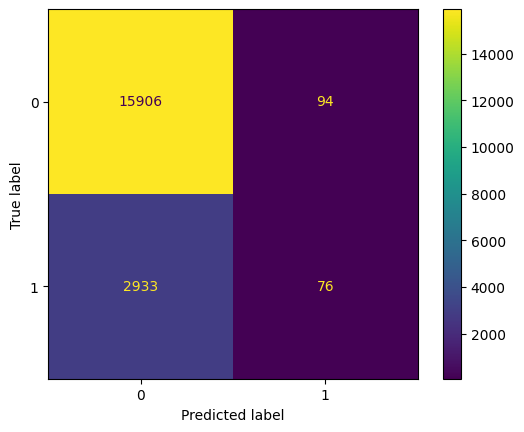

In [37]:
ConfusionMatrixDisplay.from_predictions(y_validation, y_predict_val)

In [38]:
recall_score(y_validation, y_predict_val)

0.025257560651379195

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


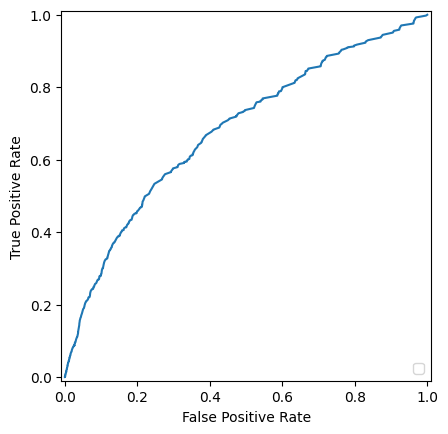

In [41]:
y_score = pipe.decision_function(X_validation)
fpr, tpr, _ = roc_curve(y_validation, y_score, pos_label=pipe.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## 7. (4pt) Use `.predict_proba` to get the values in the interval $[0,\ 1]$ instead of the classes 0 or 1.

Choose the threshold, such that recall on the Validation set is $>0.5$ (Think about this as the insuarance company's requirement.)

For the chosen threshold plot ROC-AUC (it won't change because the model stays unchanged) and Confusion Matrix. Report the Recall value.

In [42]:
y_predict_val_proba = pipe.predict_proba(X_validation)

In [43]:
y_predict_val_proba[0]

array([0.91464388, 0.08535612])

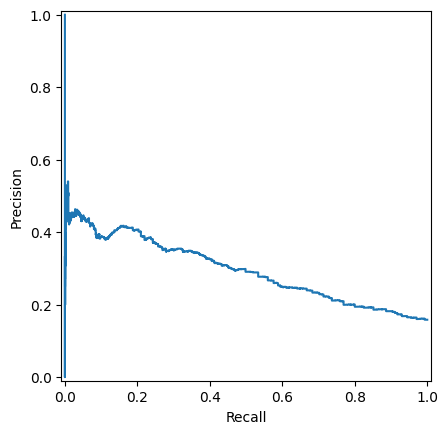

In [44]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
precision, recall, thresh = precision_recall_curve(y_validation, y_predict_val_proba[:, 1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

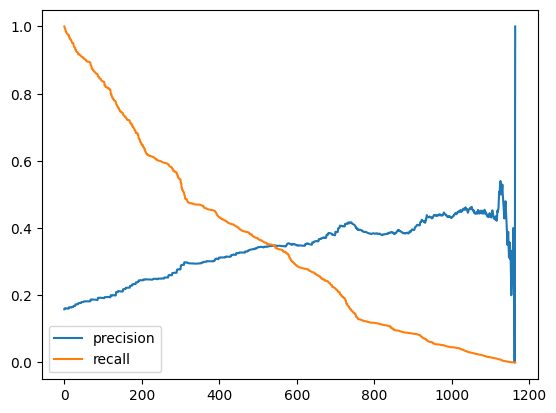

In [45]:
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.legend()

In [46]:
threshold = thresh[240]

In [47]:
y_predict_val_proba

array([[0.91464388, 0.08535612],
       [0.85297254, 0.14702746],
       [0.89502567, 0.10497433],
       ...,
       [0.59536484, 0.40463516],
       [0.92060578, 0.07939422],
       [0.89807865, 0.10192135]])

In [48]:
y_predict_val_proba[:, 1]

array([0.08535612, 0.14702746, 0.10497433, ..., 0.40463516, 0.07939422,
       0.10192135])

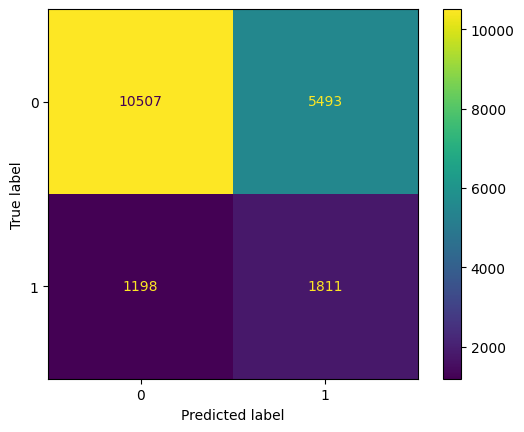

In [49]:
cm = confusion_matrix(y_validation, (y_predict_val_proba[:, 1] > thresh[240]))
cm_display = ConfusionMatrixDisplay(cm).plot()

In [50]:
recall_score(y_validation, (y_predict_val_proba[:, 1] > thresh[240]))

0.6018610834164174

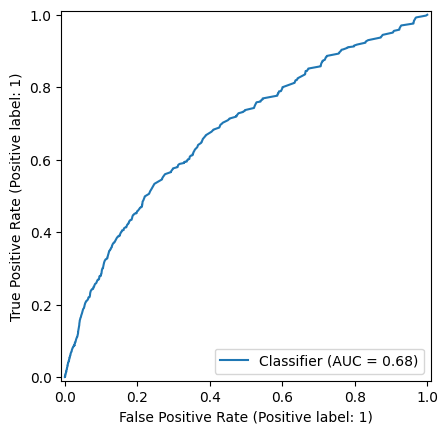

In [51]:
fpr, tpr, thresholds = roc_curve(y_validation,(y_predict_val_proba[:, 1] > thresh[240]))
RocCurveDisplay.from_predictions(y_validation, y_predict_val_proba[:,1])

## 8. (1 pt) Finally, plot ROC-AUC and Confusion Matrix, and report the Recall value on the Test set.

In [52]:
y_predict_test_proba = pipe.predict_proba(X_test)

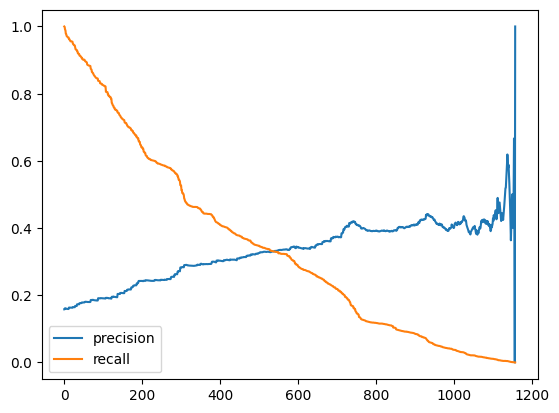

In [53]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
precision, recall, thresh = precision_recall_curve(y_test, y_predict_test_proba[:, 1])
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.legend()

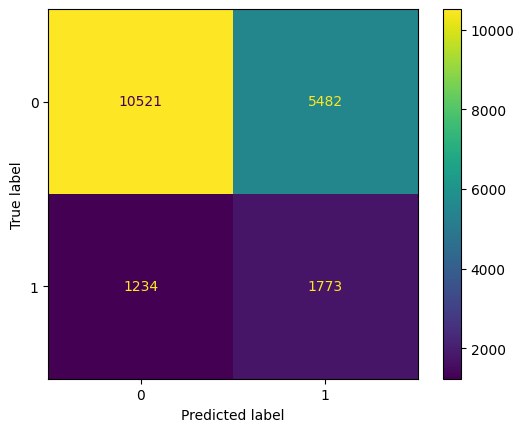

In [54]:
cm = confusion_matrix(y_test, (y_predict_test_proba[:, 1] > threshold))
cm_display = ConfusionMatrixDisplay(cm).plot()

In [55]:
recall_score(y_test, (y_predict_test_proba[:, 1] > thresh[240]))

0.591952111739275

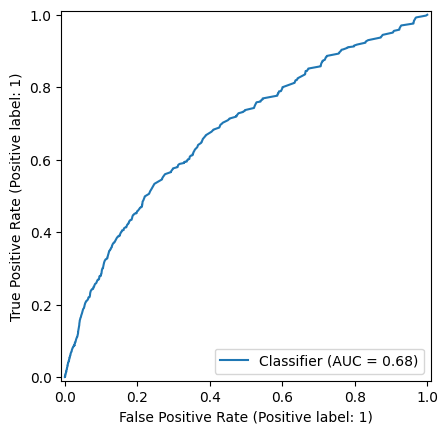

In [56]:
fpr, tpr, thresholds = roc_curve(y_validation,(y_predict_val_proba[:, 1] > threshold))
RocCurveDisplay.from_predictions(y_validation, y_predict_val_proba[:,1])

## 9. (1pt) Which features are more important?

In [57]:
pd.DataFrame({'feature': pipe[:-1].get_feature_names_out(), 'weight': np.abs(pipe[-1].coef_[0]).tolist()}).sort_values('weight', ascending=False)

,feature,weight
2,OneHot__Sex_nan,0.273914
4,remainder__CharlsonIndex,0.230254
3,remainder__ClaimsTruncated,0.186782
1,OneHot__Sex_M,0.168014
5,remainder__LengthOfStay,0.101489
6,remainder__AgeAtFirstClaim,0.069156
0,OneHot__Sex_F,0.049695


# Part 2
## 10. (5pt)

Discuss the effectiveness of each of the following ML models based on their stated accuracy. Which one is the best overall?

**a.** In a roulette game, a ball is dropped onto a spinning wheel and eventually lands in one of 38 slots. Using a camera and visual cues (the position of the wheel when the ball was dropped and its rotation speed, as well as the position and speed of the ball), an ML model can predict the slot that the ball will land in with an accuracy of 4%.

**b.** A robotic chicken crosses a busy road a thousand times per day. An ML model evaluates traffic patterns and predicts when this chicken can safely cross the street with an accuracy of 99.9%.

**c.** A deadly but curable disease affects 0.01% of the population. An ML model uses the results of a simple lab test as features and predicts this affliction with an accuracy of 99.99%.

## 11. (1pt)
The KNN model appears simpler than logistic regression, or linear regression for classification, or SVM. Why is the separating surface in KNN more complex than in the case of linear models?

## Q10 Answer

* a) This model is ineffective, particularly in a casino setting. Computing the probability of a ball landing in a random slot, which is 1/38 or approximately 0.026, is not significantly different from the model's 4% accuracy. In practice, this difference is likely negligible, making the model insufficient for financial gain in a casino.

* b) An accuracy of 99.9% is highly desirable for any model. In the given scenario, the model appears effective. If a robotic chicken crosses the road 1,00 times, 99 of those crossings will be safe, leaving only one to chance. Since the chicken is robotic, it can probably be repaired if necessary.

* c) While an accuracy of 99.99% is exceptionally high and desirable in other scenarios, a probabilistic ML model may not be the best fit for this application. Every test has a rate of false positives, and diagnosing someone with a deadly disease with a 0.01% chance of error is not acceptable. For 1000000 people, this error rate would affect 100 individuals.

*Overal* the model for robotic chicken crossing appear to be the most effective due to its accuracy.

## Q11 Answer

In models such as logistic regression and linear SVM, the separating surface is a linear function of the input variables. This means the separating surface is a straight line in two-dimensional space, a plane in three-dimensional space, or a hyperplane in higher-dimensional spaces. These linear separating surfaces are comparatively straightforward and easy to understand.

In contrast, KNN doesn't make any assumptions about the shape of the separating surface. The separating surface is instead shaped by how the training data is distributed. KNN classifies a new data point based on the majority class among its K closest neighbors in the training set. Consequently, the separating surface can be highly irregular and complex, particularly if the training data isn't linearly separable and if K is small. While this adaptability enables KNN to detect intricate patterns in the data, it may also result in separating surfaces that are more complex and harder to interpret compared to those in linear models.